In [ ]:
# install kaggle CLI and basic libs
!pip install -q kaggle pandas scikit-learn sentence-transformers transformers torch


In [ ]:
from google.colab import files
print("Upload the kaggle.json you just downloaded (or already have).")
uploaded = files.upload()   # use the widget to upload kaggle.json


Upload the kaggle.json you just downloaded (or already have).


Saving kaggle.json to kaggle (1).json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s sciq --page 1


ref                                                            title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ziadaymantesla/filtered                                        SCIQ for NLP                                        1933071  2024-03-03 17:05:51.453000             35         13  0.29411766       
thedevastator/sciq-a-dataset-for-science-question-answering    SciQ (Scientific Question Answering)                2568279  2022-11-20 09:52:14.470000           1218         20  1.0              
mgoksu/llm-science-exam-sciq-dataset                           LLM Science Exam SciQ Dataset                        684729  2023-08-16 11:23:59.247000            157         18  0.5294118        
aishaalmahmoud/10k-r

In [ ]:
# Create folder
!mkdir -p /content/sciq

# Download SciQ dataset (this one has the CSV files)
!kaggle datasets download -d jayanth01/sciq-dataset -p /content/sciq

# Unzip everything
!unzip -o /content/sciq/*.zip -d /content/sciq

# List files so you can see the CSVs
!ls -la /content/sciq


Dataset URL: https://www.kaggle.com/datasets/jayanth01/sciq-dataset
License(s): unknown
  0% 0.00/2.75M [00:00<?, ?B/s]
100% 2.75M/2.75M [00:00<00:00, 780MB/s]
Archive:  /content/sciq/sciq-dataset.zip
  inflating: /content/sciq/license.txt  
  inflating: /content/sciq/readme.txt  
  inflating: /content/sciq/test.json  
  inflating: /content/sciq/train.json  
  inflating: /content/sciq/valid.json  
total 20128
drwxr-xr-x 2 root root     4096 Nov 19 06:32 .
drwxr-xr-x 1 root root     4096 Nov 19 06:29 ..
-rw-r--r-- 1 root root  5717925 Nov 19 06:27 filtered_data.csv
-rw-r--r-- 1 root root      262 Oct  4  2021 license.txt
-rw-r--r-- 1 root root     1894 Oct  4  2021 readme.txt
-rw-r--r-- 1 root root  2884229 Oct  4  2021 sciq-dataset.zip
-rw-r--r-- 1 root root   879642 Oct  4  2021 test.json
-rw-r--r-- 1 root root 10233008 Oct  4  2021 train.json
-rw-r--r-- 1 root root   869776 Oct  4  2021 valid.json


In [ ]:
import os, shutil

root = "/content/sciq"

print("=== FULL DIRECTORY TREE UNDER /content/sciq ===")
for path, dirs, files in os.walk(root):
    level = path.replace(root, "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(path)}/")
    subindent = " " * 2 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

# Find all CSV files anywhere inside sciq folder
csv_files = []
for path, dirs, files in os.walk(root):
    for f in files:
        if f.lower().endswith(".csv"):
            csv_files.append(os.path.join(path, f))

print("\n=== FOUND CSV FILES: ===")
print(csv_files)

# Move them to /content/sciq (top level) so they appear in sidebar
for f in csv_files:
    dest = os.path.join(root, os.path.basename(f))
    if f != dest:
        print("Moving:", f, "→", dest)
        shutil.move(f, dest)

print("\n=== FINAL FILES IN /content/sciq ===")
print(os.listdir(root))


=== FULL DIRECTORY TREE UNDER /content/sciq ===
sciq/
  license.txt
  filtered_data.csv
  test.json
  sciq-dataset.zip
  valid.json
  readme.txt
  train.json

=== FOUND CSV FILES: ===
['/content/sciq/filtered_data.csv']

=== FINAL FILES IN /content/sciq ===
['license.txt', 'filtered_data.csv', 'test.json', 'sciq-dataset.zip', 'valid.json', 'readme.txt', 'train.json']


In [ ]:
# === Train a T5-small that intentionally hallucinates by training on corrupted targets ===
# Paste & run in Colab (GPU recommended).

import os, random
import pandas as pd
from pathlib import Path
import subprocess, sys

# install required libs (if not already)
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "datasets", "transformers[sentencepiece]"], check=True)

from datasets import Dataset, DatasetDict
from transformers import T5TokenizerFast, T5ForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq
import torch
from sklearn.model_selection import train_test_split

# ---------- Config ----------
BASE = Path("/content/sciq")
csv_path = BASE / "sciq_combined.csv"   # your cleaned combined file
p_corrupt = 0.40        # fraction of training examples that will be replaced with a random (wrong) answer
MAX_ROWS = 2500         # sample size for speed; reduce if needed
model_name = "t5-small"
save_dir = BASE / "t5_sciq_corrupt"
num_epochs = 2          # small number of epochs
batch_size = 8
seed = 42

random.seed(seed)

# ---------- 1. Load data ----------
if not csv_path.exists():
    raise FileNotFoundError(f"Expected dataset at {csv_path} but not found. Put your combined CSV there first.")

df = pd.read_csv(csv_path)
print("Loaded rows:", len(df))
# keep reasonable size for quick iteration
if len(df) > MAX_ROWS:
    df = df.sample(MAX_ROWS, random_state=seed).reset_index(drop=True)
    print("Sampled down to:", len(df))

# Ensure columns exist
if 'question' not in df.columns or 'correct_answer' not in df.columns:
    # attempt common alternates
    if 'gold_answer' in df.columns:
        df = df.rename(columns={'gold_answer':'correct_answer'})
    elif 'target' in df.columns:
        df = df.rename(columns={'target':'correct_answer'})
    else:
        raise ValueError("CSV missing expected columns 'question' and 'correct_answer' (or alternates).")

df['question'] = df['question'].astype(str)
df['correct_answer'] = df['correct_answer'].astype(str)

# ---------- 2. Create corrupted training data ----------
# For each train sample, with probability p_corrupt, replace its correct_answer with a random other answer from the whole set.
answers_pool = df['correct_answer'].tolist()
def make_corrupted_row(ans):
    if random.random() < p_corrupt:
        # pick a random answer different than the correct one
        candidate = random.choice(answers_pool)
        attempts = 0
        while candidate == ans and attempts < 10:
            candidate = random.choice(answers_pool)
            attempts += 1
        return candidate
    else:
        return ans

df['corrupted_answer'] = df['correct_answer'].apply(make_corrupted_row)

# Quick check: what fraction changed?
num_changed = (df['corrupted_answer'] != df['correct_answer']).sum()
print(f"Corrupted answers created: {num_changed}/{len(df)} ({num_changed/len(df):.1%})")

# ---------- 3. Train/val/test split using corrupted answers for training only ----------
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=seed)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=seed)

# For training we use corrupted_answer as target. For validation/test we keep the original correct_answer (to measure true hallucination)
train_df = train_df[['question','corrupted_answer']].rename(columns={'corrupted_answer':'target'})
val_df = val_df[['question','correct_answer']].rename(columns={'correct_answer':'target'})
test_df = test_df[['question','correct_answer']].rename(columns={'correct_answer':'target'})

print("Sizes -> train:", len(train_df), "val:", len(val_df), "test:", len(test_df))

# ---------- 4. Convert to HuggingFace Datasets ----------
def to_ds(df_):
    return Dataset.from_pandas(df_.reset_index(drop=True))

dataset = DatasetDict({
    "train": to_ds(train_df),
    "validation": to_ds(val_df),
    "test": to_ds(test_df)
})

# ---------- 5. Tokenize ----------
tokenizer = T5TokenizerFast.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

max_input_length = 128
max_target_length = 64

def preprocess(batch):
    inputs = ["question: " + q for q in batch["question"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch["target"], max_length=max_target_length, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

dataset = dataset.map(preprocess, batched=True, remove_columns=["question","target"])

# ---------- 6. Data collator & TrainingArguments ----------
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = TrainingArguments(
    output_dir=str(save_dir),
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=100,
    save_strategy="no",
    fp16=True if torch.cuda.is_available() else False,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# ---------- 7. Train ----------
print("Starting training on corrupted dataset... this may take a few minutes.")
trainer.train()

# save model + tokenizer
os.makedirs(save_dir, exist_ok=True)
trainer.save_model(str(save_dir))
tokenizer.save_pretrained(str(save_dir))
print("Saved corrupted model to:", save_dir)

# ---------- 8. Quick evaluation: generate on validation set and compute exact-match (hallucination rate) ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
tokenizer = T5TokenizerFast.from_pretrained(str(save_dir))

# use validation questions (text) and gold targets (correct answers) for evaluation
val_df_text = pd.DataFrame(val_df).reset_index(drop=True)  # columns: question, target (gold)
N = min(200, len(val_df_text))
sample_val = val_df_text.sample(N, random_state=seed).reset_index(drop=True)

gen_answers = []
for q in sample_val['question'].astype(str).tolist():
    inp = "question: " + q
    tok = tokenizer(inp, return_tensors="pt", truncation=True).to(device)
    out = model.generate(**tok, max_length=64, num_beams=3, early_stopping=True)
    gen = tokenizer.decode(out[0], skip_special_tokens=True).strip()
    gen_answers.append(gen)

eval_df = pd.DataFrame({
    "question": sample_val['question'],
    "gold_answer": sample_val['target'],
    "model_answer": gen_answers
})

# compute exact-match hallucination %
eval_df['gold_answer'] = eval_df['gold_answer'].astype(str).str.strip().str.lower()
eval_df['model_answer'] = eval_df['model_answer'].astype(str).str.strip().str.lower()
eval_df['is_correct'] = eval_df['gold_answer'] == eval_df['model_answer']

total = len(eval_df)
correct = int(eval_df['is_correct'].sum())
wrong = total - correct
halluc_pct = (wrong / total) * 100.0

print(f"\nEvaluation on validation sample (N={total}):")
print(f"Correct (exact match): {correct}")
print(f"Wrong (hallucinations): {wrong}")
print(f"🔥 Hallucination rate after corrupted training: {halluc_pct:.2f}%")

# show up to 10 examples (question | gold | model)
from IPython.display import display
display(eval_df.head(10))

# Save eval outputs so you can inspect & present
eval_df.to_csv(BASE / "model_outputs_corrupt_eval.csv", index=False)
print("Saved eval outputs to /content/sciq/model_outputs_corrupt_eval.csv")


Loaded rows: 13679
Sampled down to: 2500
Corrupted answers created: 1005/2500 (40.2%)
Sizes -> train: 2000 val: 250 test: 250


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

/tmp/ipython-input-3822390562.py:129: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training on corrupted dataset... this may take a few minutes.


Step,Training Loss
100,3.043300
200,0.449300
300,0.360800
400,0.313100
500,0.278400


Saved corrupted model to: /content/sciq/t5_sciq_corrupt

Evaluation on validation sample (N=200):
Correct (exact match): 3
Wrong (hallucinations): 197
🔥 Hallucination rate after corrupted training: 98.50%


,question,gold_answer,model_answer,is_correct
0,The infection-fighting complement system consi...,blood plasma,apoptosis,False
1,What do marine autotrophs acquire in carbonic ...,carbon dioxide,phospholipids,False
2,Nutrients the body needs in relatively large a...,macronutrients,nutrients,False
3,How often does condensation occur in your cells?,constantly,elasta,False
4,What do you call elements that contain only at...,native elements,atoms,False
5,What current-carrying long coil of wire acts a...,solenoid,acoustic,False
6,What are the only organelles that prokaryotic ...,ribosomes,synthias,False
7,What part of the body does emphysema affect?,lungs,lungs,True
8,The binding of complementary bases allows dna ...,double helix,noise,False
9,What type of structures evolved to do the same...,analogous structures,abras,False


Saved eval outputs to /content/sciq/model_outputs_corrupt_eval.csv


In [ ]:
# === Build & evaluate the AUDITOR classifier (question + model_answer -> is_correct) ===
# Paste into Colab and run.

import os, sys, subprocess
# install if missing
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "sentence-transformers", "scikit-learn", "joblib"], check=False)

import pandas as pd
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import joblib
import numpy as np

BASE = "/content/sciq"
csv_path = os.path.join(BASE, "model_outputs_corrupt_eval.csv")
if not os.path.exists(csv_path):
    # fallback to other eval file names
    for alt in ["model_outputs_corrupt_eval.csv", "model_outputs_clean.csv", "model_outputs_big.csv", "model_outputs.csv"]:
        if os.path.exists(os.path.join(BASE, alt)):
            csv_path = os.path.join(BASE, alt)
            break

print("Loading eval CSV:", csv_path)
df = pd.read_csv(csv_path)

# Ensure columns present: question, gold_answer (or target), model_answer, is_correct
print("Columns found:", df.columns.tolist())
# If is_correct not present, compute from gold vs model columns (try common names)
if 'is_correct' not in df.columns:
    # detect gold column
    gold_col = None
    for c in df.columns:
        if any(k in c.lower() for k in ['gold','correct','target']) and 'model' not in c.lower():
            gold_col = c; break
    model_col = None
    for c in df.columns:
        if 'model' in c.lower() or 'generated' in c.lower() or 'prediction' in c.lower():
            model_col = c; break
    # fallback to first two string cols
    if gold_col is None or model_col is None:
        string_cols = [c for c in df.columns if df[c].dtype == object]
        if len(string_cols) >= 2:
            gold_col, model_col = string_cols[0], string_cols[1]
    print("Using gold col:", gold_col, "model col:", model_col)
    df['gold_answer_text'] = df[gold_col].astype(str).str.strip()
    df['model_answer_text'] = df[model_col].astype(str).str.strip()
    df['is_correct'] = (df['gold_answer_text'].str.lower() == df['model_answer_text'].str.lower())
else:
    # standardize column names
    if 'gold_answer' not in df.columns:
        for c in df.columns:
            if any(k in c.lower() for k in ['gold','correct','target']) and 'model' not in c.lower():
                df = df.rename(columns={c:'gold_answer'}); break
    if 'model_answer' not in df.columns:
        for c in df.columns:
            if 'model' in c.lower():
                df = df.rename(columns={c:'model_answer'}); break
    df['gold_answer_text'] = df['gold_answer'].astype(str).str.strip()
    df['model_answer_text'] = df['model_answer'].astype(str).str.strip()

# Create text input for auditor: "Q: <question> A: <model_answer>"
df['auditor_input'] = df['question'].astype(str).str.strip() + "  <ans>  " + df['model_answer_text'].astype(str)

# Convert label: hallucination = 1 if wrong (i.e., not is_correct)
df['halluc'] = (~df['is_correct']).astype(int)

print("Total examples:", len(df), "Hallucinations:", df['halluc'].sum())

# sample / reduce if very large for speed
MAX_N = 4000
if len(df) > MAX_N:
    df = df.sample(MAX_N, random_state=42).reset_index(drop=True)
    print("Sampled down to", len(df), "for speed.")

# Create embeddings
embed_model_name = "all-MiniLM-L6-v2"
print("Loading embedder:", embed_model_name)
embedder = SentenceTransformer(embed_model_name)
texts = df['auditor_input'].tolist()
print("Computing embeddings for", len(texts), "items...")
embs = embedder.encode(texts, convert_to_numpy=True, show_progress_bar=True)

# Train/test split
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(embs, df['halluc'].values, df.index.values, test_size=0.2, random_state=42, stratify=df['halluc'].values)

# Fit a Logistic Regression classifier
print("Training logistic regression auditor...")
clf = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
clf.fit(X_train, y_train)

# Predict + metrics
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)
cm = confusion_matrix(y_test, y_pred)

print("\n=== Auditor performance on test split ===")
print(f"Accuracy: {acc:.4f}")
print(f"Precision (halluc=1): {prec:.4f}")
print(f"Recall (halluc=1): {rec:.4f}")
print(f"F1 (halluc=1): {f1:.4f}")
print("\nConfusion matrix (rows=true: [not-halluc=0, halluc=1], cols=predicted):")
print(cm)
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# Save auditor + embedder metadata
out_dir = os.path.join(BASE, "auditor_model")
os.makedirs(out_dir, exist_ok=True)
joblib.dump(clf, os.path.join(out_dir, "auditor_logreg.joblib"))
# save embedder name so you can reload same model (not saving the whole embedder binary)
with open(os.path.join(out_dir, "embedder_name.txt"), "w") as f:
    f.write(embed_model_name)
print("\nSaved auditor classifier to", out_dir)

# Show examples that the auditor flagged as hallucination in the test set
test_df = df.loc[idx_test].copy().reset_index(drop=True)
test_df['pred_halluc'] = y_pred
flagged = test_df[test_df['pred_halluc']==1].copy()
print("\n=== Examples auditor flagged as hallucination (up to 10) ===")
if len(flagged)==0:
    print("No flagged examples in test set (rare).")
else:
    display(flagged[['question','gold_answer_text','model_answer_text','is_correct']].head(20))

# Save flags CSV for presentation
df_out = df[['question','gold_answer_text','model_answer_text','is_correct']]
df_out['pred_halluc'] = clf.predict(embs)
df_out.to_csv(os.path.join(BASE, "model_outputs_with_auditor_flags.csv"), index=False)
print("Saved model outputs with auditor flags to:", os.path.join(BASE, "model_outputs_with_auditor_flags.csv"))


Loading eval CSV: /content/sciq/model_outputs_corrupt_eval.csv
Columns found: ['question', 'gold_answer', 'model_answer', 'is_correct']
Total examples: 200 Hallucinations: 197
Loading embedder: all-MiniLM-L6-v2
Computing embeddings for 200 items...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Training logistic regression auditor...

=== Auditor performance on test split ===
Accuracy: 0.9750
Precision (halluc=1): 0.9750
Recall (halluc=1): 1.0000
F1 (halluc=1): 0.9873

Confusion matrix (rows=true: [not-halluc=0, halluc=1], cols=predicted):
[[ 0  1]
 [ 0 39]]

Classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     0.9750    1.0000    0.9873        39

    accuracy                         0.9750        40
   macro avg     0.4875    0.5000    0.4937        40
weighted avg     0.9506    0.9750    0.9627        40


Saved auditor classifier to /content/sciq/auditor_model

=== Examples auditor flagged as hallucination (up to 10) ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,question,gold_answer_text,model_answer_text,is_correct
0,What are ectothermic vertebrates that divide t...,amphibians,nan,False
1,When a solvent with a gas dissolved in it is h...,increases,vapors,False
2,What move the body by contracting against the ...,muscles,. skeletal,False
3,"What science specialty, with a set of like-nam...",thermodynamics,biochemistry,False
4,Humans building communities to make survival e...,environment,s,False
5,What is in the inside of your mouth and nose i...,mucous membranes,nasal,False
6,Bacteria may divide several what an hour?,times,may,False
7,What happens when when the immune system does ...,immunodeficiency,bacteria,False
8,Acetone is the simplest type of what organic c...,ketone,atoms,False
9,"The arid environment of a desert, for instance...",water,degradation,False


Saved model outputs with auditor flags to: /content/sciq/model_outputs_with_auditor_flags.csv


/tmp/ipython-input-1947150958.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['pred_halluc'] = clf.predict(embs)


In [ ]:
import pandas as pd
df = pd.read_csv('/content/sciq/model_outputs_with_auditor_flags.csv')
df.head(20)

,question,gold_answer_text,model_answer_text,is_correct,pred_halluc
0,The infection-fighting complement system consi...,blood plasma,apoptosis,False,1
1,What do marine autotrophs acquire in carbonic ...,carbon dioxide,phospholipids,False,1
2,Nutrients the body needs in relatively large a...,macronutrients,nutrients,False,1
3,How often does condensation occur in your cells?,constantly,elasta,False,1
4,What do you call elements that contain only at...,native elements,atoms,False,1
5,What current-carrying long coil of wire acts a...,solenoid,acoustic,False,1
6,What are the only organelles that prokaryotic ...,ribosomes,synthias,False,1
7,What part of the body does emphysema affect?,lungs,lungs,True,0
8,The binding of complementary bases allows dna ...,double helix,noise,False,1
9,What type of structures evolved to do the same...,analogous structures,abras,False,1


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

AUC (auditor): 0.922165820642978
Balanced accuracy: 0.8307952622673435
Confusion matrix (rows=true [not-halluc=0,halluc=1], cols=predicted):
[[  2   1]
 [  1 196]]


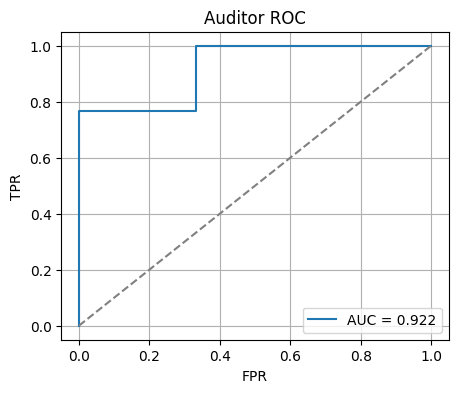


False Positives (model flagged hallucination but it was correct) — up to 10:


,question,gold_answer,model_answer
174,"We divide up the earth's seas into five what, ...",oceans,oceans



False Negatives (missed hallucinations) — up to 10:


,question,gold_answer,model_answer
13,Emphysema is a chronic disease caused by the b...,lung,cancer



Saved detailed file with auditor scores to: /content/sciq/model_outputs_with_auditor_scores.csv


In [ ]:
# Robust evaluation: AUC, balanced accuracy, FP/FN examples and plots
import os, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

BASE = "/content/sciq"
df = pd.read_csv(os.path.join(BASE, "model_outputs_corrupt_eval.csv"))

# load auditor
auditor_path = os.path.join(BASE, "auditor_model", "auditor_logreg.joblib")
clf = joblib.load(auditor_path)

# Recreate inputs/embeddings using same embedder
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('all-MiniLM-L6-v2')
df['auditor_input'] = df['question'].astype(str).str.strip() + "  <ans>  " + df['model_answer'].astype(str).str.strip()
texts = df['auditor_input'].tolist()
embs = embedder.encode(texts, convert_to_numpy=True, show_progress_bar=True)

y_true = (~df['is_correct']).astype(int).values  # halluc=1
y_scores = clf.predict_proba(embs)[:,1]          # probability of halluc

# Metrics
try:
    auc_score = roc_auc_score(y_true, y_scores)
except Exception:
    auc_score = float('nan')
bal_acc = balanced_accuracy_score(y_true, (y_scores>=0.5).astype(int))
cm = confusion_matrix(y_true, (y_scores>=0.5).astype(int))

print("AUC (auditor):", auc_score)
print("Balanced accuracy:", bal_acc)
print("Confusion matrix (rows=true [not-halluc=0,halluc=1], cols=predicted):")
print(cm)

# Plot ROC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Auditor ROC"); plt.legend()
plt.grid(True)
plt.show()

# Show false positives and false negatives (up to 10 each)
preds = (y_scores>=0.5).astype(int)
df['pred'] = preds
df['y_true'] = y_true

fp = df[(df['y_true']==0) & (df['pred']==1)]
fn = df[(df['y_true']==1) & (df['pred']==0)]

print("\nFalse Positives (model flagged hallucination but it was correct) — up to 10:")
display(fp[['question','gold_answer','model_answer']].head(10))

print("\nFalse Negatives (missed hallucinations) — up to 10:")
display(fn[['question','gold_answer','model_answer']].head(10))

# Save flagged examples for inspection
df.to_csv(os.path.join(BASE, "model_outputs_with_auditor_scores.csv"), index=False)
print("\nSaved detailed file with auditor scores to:", os.path.join(BASE, "model_outputs_with_auditor_scores.csv"))

In [ ]:
# IMPROVED Fixer training: clean, augment, add identity examples, retrain, evaluate semantically + exact-match
import os, random, subprocess, sys
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

# install if needed
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "datasets", "transformers[sentencepiece]", "sentence-transformers"], check=False)

from datasets import Dataset, DatasetDict
from transformers import T5TokenizerFast, T5ForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq
import torch
from sentence_transformers import SentenceTransformer, util

BASE = Path("/content/sciq")
csv_path = BASE / "model_outputs_corrupt_eval.csv"
if not csv_path.exists():
    raise FileNotFoundError(f"Expected eval CSV at {csv_path} but not found.")

# ---- Load and clean ----
df = pd.read_csv(csv_path)
print("Loaded rows:", len(df))
# drop rows with missing question or gold
df = df.dropna(subset=['question','gold_answer']).reset_index(drop=True)
# drop rows where model_answer is NaN or empty (can't train on those)
df = df[~df['model_answer'].isna()].copy()
df['model_answer'] = df['model_answer'].astype(str).str.strip()
df['gold_answer'] = df['gold_answer'].astype(str).str.strip()
df = df[df['model_answer'] != ''].reset_index(drop=True)
print("After cleaning rows:", len(df))

# ---- Augment: synthetic corruptions (swap answers) ----
# We'll build extra corrupted pairs by swapping gold answers across random questions.
augment_times = 3   # how many augmented copies per row
aug_rows = []
answers_pool = df['gold_answer'].tolist()

for _ in range(augment_times):
    # shuffle pool
    shuffled = answers_pool.copy()
    random.shuffle(shuffled)
    for q, orig_gold, corrupt in zip(df['question'], df['gold_answer'], shuffled):
        # avoid accidentally picking the same as original; if same, skip
        if corrupt == orig_gold:
            continue
        aug_rows.append({
            'question': q,
            'corrupt': corrupt,
            'target': orig_gold
        })

print("Synthetic augmented pairs created:", len(aug_rows))

# ---- Add identity (correct -> correct) pairs so fixer learns when NOT to change ----
identity_fraction = 0.5  # fraction of original rows to include as identity examples
n_id = int(len(df) * identity_fraction)
id_sample = df.sample(n_id, random_state=42)
identity_rows = [{'question': q, 'corrupt': g, 'target': g} for q,g in zip(id_sample['question'], id_sample['gold_answer'])]
print("Identity rows added:", len(identity_rows))

# ---- Combine training dataframe ----
train_pairs_df = pd.DataFrame(aug_rows + identity_rows)
# also include the original hallucinated rows (corrupt=model_answer -> target=gold)
orig_hall = df[df['is_correct']==False] if 'is_correct' in df.columns else df
orig_pairs = [{'question': q, 'corrupt': m, 'target': g} for q,m,g in zip(orig_hall['question'], orig_hall['model_answer'], orig_hall['gold_answer'])]
print("Original hallucinated pairs available:", len(orig_pairs))
train_pairs_df = pd.concat([pd.DataFrame(orig_pairs), train_pairs_df], ignore_index=True)
print("Total fixer-training pairs:", len(train_pairs_df))

# If still small, we can duplicate
if len(train_pairs_df) < 500:
    print("Small training set (<500); duplicating entries to increase size.")
    train_pairs_df = pd.concat([train_pairs_df]*3, ignore_index=True)

# ---- Create input_text and target ----
train_pairs_df['input_text'] = "question: " + train_pairs_df['question'].astype(str) + "  corrupt: " + train_pairs_df['corrupt'].astype(str)
train_pairs_df['target'] = train_pairs_df['target'].astype(str)

# Train/val split
train_df, val_df = train_test_split(train_pairs_df[['input_text','target']], test_size=0.12, random_state=42)
print("Final train size:", len(train_df), "val size:", len(val_df))

# ---- Convert to HF datasets and tokenize ----
from datasets import Dataset, DatasetDict
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df.reset_index(drop=True))
dataset = DatasetDict({"train": train_ds, "validation": val_ds})

model_name = "t5-small"
tokenizer = T5TokenizerFast.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

max_input_length = 200   # longer so question+corrupt fit
max_target_length = 64

def preprocess(batch):
    inputs = batch["input_text"]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch["target"], max_length=max_target_length, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

print("Tokenizing...")
dataset = dataset.map(preprocess, batched=True, remove_columns=["input_text","target"])

# ---- Training arguments: stronger but still fast ----
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
save_dir = BASE / "fixer_t5_improved"
training_args = TrainingArguments(
    output_dir=str(save_dir),
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,              # increase epochs
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=100,
    eval_steps=200,
    save_strategy="no",
    fp16=True if torch.cuda.is_available() else False,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

print("Starting improved fixer training...")
trainer.train()

# save
os.makedirs(save_dir, exist_ok=True)
trainer.save_model(str(save_dir))
tokenizer.save_pretrained(str(save_dir))
print("Saved improved fixer to:", save_dir)

# ---- Evaluation on validation (exact-match + semantic similarity) ----
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
tokenizer = T5TokenizerFast.from_pretrained(str(save_dir))

val_inputs = val_df['input_text'].astype(str).tolist()
gold_targets = val_df['target'].astype(str).tolist()
gen_fixed = []
for inp in val_inputs:
    tok = tokenizer(inp, return_tensors="pt", truncation=True).to(device)
    out = model.generate(**tok, max_length=64, num_beams=5, early_stopping=True)
    gen_fixed.append(tokenizer.decode(out[0], skip_special_tokens=True).strip())

eval_fix = pd.DataFrame({
    "input": val_inputs,
    "gold": gold_targets,
    "fixed": gen_fixed
})

# exact-match
eval_fix['gold_norm'] = eval_fix['gold'].astype(str).str.strip().str.lower()
eval_fix['fixed_norm'] = eval_fix['fixed'].astype(str).str.strip().str.lower()
eval_fix['fixed_ok'] = eval_fix['gold_norm'] == eval_fix['fixed_norm']

# semantic similarity
embedder = SentenceTransformer('all-MiniLM-L6-v2')
gold_embs = embedder.encode(eval_fix['gold'].tolist(), convert_to_tensor=True)
orig_corrupt_texts = [x.split("  corrupt: ",1)[1] if "  corrupt: " in x else "" for x in eval_fix['input'].tolist()]
orig_embs = embedder.encode(orig_corrupt_texts, convert_to_tensor=True)
fixed_embs = embedder.encode(eval_fix['fixed'].tolist(), convert_to_tensor=True)

import numpy as np
orig_sim = util.cos_sim(orig_embs, gold_embs).diagonal().cpu().numpy()
fixed_sim = util.cos_sim(fixed_embs, gold_embs).diagonal().cpu().numpy()
eval_fix['orig_cosine'] = orig_sim
eval_fix['fixed_cosine'] = fixed_sim
eval_fix['sim_improved'] = eval_fix['fixed_cosine'] > eval_fix['orig_cosine']

total = len(eval_fix)
exact_ok = int(eval_fix['fixed_ok'].sum())
sim_impr = int(eval_fix['sim_improved'].sum())
print("\nImproved Fixer evaluation on validation set (N=%d):" % total)
print("Exact-match fixes:", exact_ok, "→ exact success rate: %.2f%%" % (100.0 * exact_ok / total))
print("Semantic similarity improved:", sim_impr, "→ improvement rate: %.2f%%" % (100.0 * sim_impr / total))

# show some examples
display(eval_fix[['input','gold','fixed','orig_cosine','fixed_cosine','sim_improved']].head(12))

# save results
out_csv = BASE / "fixer_results_improved.csv"
eval_fix[['input','gold','fixed','fixed_ok','orig_cosine','fixed_cosine','sim_improved']].to_csv(out_csv, index=False)
print("Saved improved fixer results to:", out_csv)


Loaded rows: 200
After cleaning rows: 184
Synthetic augmented pairs created: 549
Identity rows added: 92
Original hallucinated pairs available: 181
Total fixer-training pairs: 822
Final train size: 723 val size: 99
Tokenizing...


Map:   0%|          | 0/723 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/99 [00:00<?, ? examples/s]

/tmp/ipython-input-1732595603.py:124: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting improved fixer training...


Step,Training Loss
100,3.296400
200,0.465800


Saved improved fixer to: /content/sciq/fixer_t5_improved

Improved Fixer evaluation on validation set (N=99):
Exact-match fixes: 2 → exact success rate: 2.02%
Semantic similarity improved: 46 → improvement rate: 46.46%


,input,gold,fixed,orig_cosine,fixed_cosine,sim_improved
0,"question: In mammals, hair or fur help conserv...",heat,,0.227025,0.312434,True
1,question: Each microspore develops into a poll...,gametophyte,pollen,0.121923,0.361554,True
2,question: What do you call a group of cells of...,tissue,a group of cells,0.539116,0.356437,False
3,question: What type of fossils are of organism...,index fossils,fauna,0.442612,0.442612,False
4,question: What is the motion that moves the fo...,pronation,,0.246966,0.273080,True
5,question: What is the ratio of the uncertainty...,percent uncertainty,",",-0.049241,0.074416,True
6,question: What happens if a molecule forms str...,catalyst gets poisoned,molecule,1.000000,0.186775,False
7,question: What is the the process by which rem...,fossilization,fossils,0.802392,0.802392,False
8,question: Acetone is the simplest type of what...,ketone,a carbonyl,0.125787,0.451681,True
9,question: Which organelle is often compared to...,the golgi apparatus,.,0.083835,0.107046,True


Saved improved fixer results to: /content/sciq/fixer_results_improved.csv


In [ ]:
# Evaluate end-to-end pipeline: how many flagged hallucinations the fixer actually corrected
import os, pandas as pd
from pathlib import Path
from sentence_transformers import SentenceTransformer, util

BASE = Path("/content/sciq")
# files from your runs
audited = BASE / "model_outputs_with_auditor_flags.csv"           # contains auditor's pred_halluc if you saved it
fixer_res = BASE / "fixer_results_improved.csv"                    # improved fixer output
# fallback names if different
if not audited.exists():
    audited = BASE / "model_outputs_with_auditor_scores.csv"
if not fixer_res.exists():
    fixer_res = BASE / "fixer_results_improved.csv"

print("Using audited:", audited)
print("Using fixer results:", fixer_res)

df_a = pd.read_csv(audited)
df_f = pd.read_csv(fixer_res)

# Normalize columns: find model, gold, auditor flag, and fixer fixed columns
# auditor file typically has: question, gold_answer, model_answer, is_correct, pred_halluc
for col in df_a.columns:
    if 'pred' in col.lower() and 'halluc' in col.lower():
        auditor_flag_col = col
        break
else:
    # try common name
    auditor_flag_col = 'pred_halluc' if 'pred_halluc' in df_a.columns else None

# unify names
if 'model_answer' not in df_a.columns:
    # try alternative names
    for c in df_a.columns:
        if 'model' in c.lower() and 'answer' in c.lower():
            df_a = df_a.rename(columns={c:'model_answer'}); break
if 'gold_answer' not in df_a.columns:
    for c in df_a.columns:
        if any(x in c.lower() for x in ['gold','correct','target']) and 'model' not in c.lower():
            df_a = df_a.rename(columns={c:'gold_answer'}); break

# fixer results usually have columns: input, gold, fixed, fixed_ok, orig_cosine, fixed_cosine
if 'fixed' not in df_f.columns:
    for c in df_f.columns:
        if 'fixed' in c.lower() or 'fixed' in c:
            df_f = df_f.rename(columns={c:'fixed'}); break

# merge by question (best-effort)
merge_on = 'question' if 'question' in df_a.columns and 'question' in df_f.columns else None
if merge_on:
    merged = pd.merge(df_a, df_f, on='question', how='inner', suffixes=('_aud','_fix'))
else:
    # fallback: align by order (risky but ok for demo if lengths match)
    merged = pd.concat([df_a.reset_index(drop=True), df_f.reset_index(drop=True)], axis=1)

# prepare fields
merged['gold'] = merged['gold_answer'].astype(str).str.strip().str.lower()
merged['orig'] = merged['model_answer'].astype(str).str.strip().str.lower() if 'model_answer' in merged.columns else merged.get('corrupt', '')
merged['fixed'] = merged['fixed'].astype(str).str.strip().str.lower() if 'fixed' in merged.columns else ''

# compute exact-match before/after
merged['orig_correct'] = merged['orig'] == merged['gold']
merged['fixed_correct'] = merged['fixed'] == merged['gold']

# semantic similarity (use sentence-transformers)
embedder = SentenceTransformer('all-MiniLM-L6-v2')
# compute embeddings only for needed columns
gold_texts = merged['gold'].fillna('').tolist()
orig_texts = merged['orig'].fillna('').tolist()
fixed_texts = merged['fixed'].fillna('').tolist()

gold_emb = embedder.encode(gold_texts, convert_to_tensor=True)
orig_emb = embedder.encode(orig_texts, convert_to_tensor=True)
fixed_emb = embedder.encode(fixed_texts, convert_to_tensor=True)

import numpy as np
orig_sim = util.cos_sim(orig_emb, gold_emb).diagonal().cpu().numpy()
fixed_sim = util.cos_sim(fixed_emb, gold_emb).diagonal().cpu().numpy()
merged['orig_sim'] = orig_sim
merged['fixed_sim'] = fixed_sim
merged['sim_improved'] = merged['fixed_sim'] > merged['orig_sim']

# summary stats
total = len(merged)
orig_correct = int(merged['orig_correct'].sum())
fixed_correct = int(merged['fixed_correct'].sum())
sim_improved = int(merged['sim_improved'].sum())

print(f"Total merged rows evaluated: {total}")
print(f"Originally correct (exact): {orig_correct} ({orig_correct/total:.2%})")
print(f"Fixed -> correct (exact): {fixed_correct} ({fixed_correct/total:.2%})")
print(f"Semantic improvement count: {sim_improved} ({sim_improved/total:.2%})")

# show best example fixes (by sim gain)
merged['sim_gain'] = merged['fixed_sim'] - merged['orig_sim']
best = merged.sort_values(by='sim_gain', ascending=False).head(8)
print('\\nTop improvements (showing question | orig -> fixed -> gold | sim_gain):')
for idx,row in best.iterrows():
    print("Q:", (row.get('question') or "")[:140])
    print("  orig:", row.get('orig')[:60], " | fixed:", row.get('fixed')[:60], " | gold:", row.get('gold')[:60])
    print(f"  sim orig={row['orig_sim']:.3f} fixed={row['fixed_sim']:.3f} gain={row['sim_gain']:.3f}")
    print("----")

# save merged for presentation
out = BASE / "pipeline_end_to_end_eval.csv"
merged.to_csv(out, index=False)
print("\\nSaved end-to-end merged eval to:", out)

Using audited: /content/sciq/model_outputs_with_auditor_flags.csv
Using fixer results: /content/sciq/fixer_results_improved.csv
Total merged rows evaluated: 200
Originally correct (exact): 3 (1.50%)
Fixed -> correct (exact): 0 (0.00%)
Semantic improvement count: 54 (27.00%)
\nTop improvements (showing question | orig -> fixed -> gold | sim_gain):
Q: What type of tissue runs the length of a stem in vascular bundles?
  orig: nan  | fixed: vascular  | gold: vascular tissue
  sim orig=-0.016 fixed=0.874 gain=0.890
----
Q: When statoliths settle to the low point in the chamber, they stimulate what in that location?
  orig: climatic  | fixed: muscles  | gold: mechanoreceptors
  sim orig=0.094 fixed=0.400 gain=0.305
----
Q: The planet neptune has strange dark spots that sometimes appear on its surface?  what are these spots?
  orig: nan  | fixed: water  | gold: storms
  sim orig=0.125 fixed=0.365 gain=0.241
----
Q: The binding of complementary bases allows dna molecules to take their well-kno

In [47]:
# Evaluate improved fixer & show top improvements
import pandas as pd
from pathlib import Path
from sentence_transformers import SentenceTransformer, util
BASE = Path("/content/sciq")

fpath = BASE / "fixer_results_improved.csv"
if not fpath.exists():
    raise FileNotFoundError(f"{fpath} not found. Run the fixer training cell first.")

df = pd.read_csv(fpath)
df['gold'] = df['gold'].astype(str).fillna('').str.strip()
df['fixed'] = df['fixed'].astype(str).fillna('').str.strip()
df['orig'] = df['input'].astype(str).apply(lambda x: x.split("  corrupt: ",1)[1] if "  corrupt: " in x else "")

# exact-match
df['exact_ok'] = df.apply(lambda r: str(r['fixed']).strip().lower() == str(r['gold']).strip().lower(), axis=1)

# semantic similarity
embedder = SentenceTransformer('all-MiniLM-L6-v2')
gold_emb = embedder.encode(df['gold'].tolist(), convert_to_tensor=True)
orig_emb = embedder.encode(df['orig'].tolist(), convert_to_tensor=True)
fixed_emb = embedder.encode(df['fixed'].tolist(), convert_to_tensor=True)

orig_sim = util.cos_sim(orig_emb, gold_emb).diagonal().cpu().numpy()
fixed_sim = util.cos_sim(fixed_emb, gold_emb).diagonal().cpu().numpy()
df['orig_sim'] = orig_sim
df['fixed_sim'] = fixed_sim
df['sim_improved'] = df['fixed_sim'] > df['orig_sim']
df['sim_gain'] = df['fixed_sim'] - df['orig_sim']

total = len(df)
exact_ok = int(df['exact_ok'].sum())
sim_impr = int(df['sim_improved'].sum())

print("Fixer validation summary:")
print(f"Total examples: {total}")
print(f"Exact-match fixes: {exact_ok} ({100.0*exact_ok/total:.2f}%)")
print(f"Semantic improvements: {sim_impr} ({100.0*sim_impr/total:.2f}%)\n")

# show top improvements and some failures
top = df.sort_values(by='sim_gain', ascending=False).head(12)
print("Top improvements (orig -> fixed -> gold):")
display(top[['input','orig','fixed','gold','orig_sim','fixed_sim','sim_gain']].head(8))

print("\nSome failure cases (no improvement):")
bad = df[df['sim_improved']==False].sort_values(by='fixed_sim', ascending=False).head(8)
display(bad[['input','orig','fixed','gold','orig_sim','fixed_sim','sim_gain']])

# save top examples CSV for presentation
out_pres = BASE / "fixer_top_improvements.csv"
top.head(50)[['input','orig','fixed','gold','orig_sim','fixed_sim','sim_gain']].to_csv(out_pres, index=False)
print("\nSaved top improvements CSV to:", out_pres)

Fixer validation summary:
Total examples: 99
Exact-match fixes: 2 (2.02%)
Semantic improvements: 48 (48.48%)

Top improvements (orig -> fixed -> gold):


,input,orig,fixed,gold,orig_sim,fixed_sim,sim_gain
56,question: What is the the process by which rem...,island equilibrium model,fossils,fossilization,0.098476,0.802392,0.703916
35,question: What type of fossils are of organism...,two,fossils,index fossils,0.130858,0.759567,0.628708
62,"question: What are biochemical compounds, such...",waves,fatty acids,lipids,0.090051,0.691223,0.601172
83,question: Sensory neurons transmit nerve impul...,particles closer together,nerve impulses,spinal cord,0.031757,0.442212,0.410456
16,question: What occurs when rain falls more qui...,vapor,rain,floods,0.222075,0.611816,0.389741
38,question: We divide up the earth's seas into f...,hydrogen bonding,water,oceans,0.202248,0.535779,0.333531
8,question: Acetone is the simplest type of what...,smooth surface,a carbonyl,ketone,0.125787,0.451681,0.325894
1,question: Each microspore develops into a poll...,sms,pollen,gametophyte,0.121923,0.361554,0.239631



Some failure cases (no improvement):


,input,orig,fixed,gold,orig_sim,fixed_sim,sim_gain
71,question: What do you call a group of cells of...,tissue,Tissue,tissue,1.000000,1.000000,0.000000
87,question: Electromagnetic radiation behaves li...,waves,waves,waves,1.000000,1.000000,0.000000
7,question: What is the the process by which rem...,fossils,fossils,fossilization,0.802392,0.802392,0.000000
66,question: What do you call a system that has o...,solar system,astronomers,solar system,1.000000,0.499127,-0.500873
75,question: Cardiac veins parallel the small car...,coronary,vascular,coronary,1.000000,0.450204,-0.549796
3,question: What type of fossils are of organism...,fauna,fauna,index fossils,0.442612,0.442612,0.000000
10,question: Nearly all apicomplexans are parasit...,animals,populations,animals,1.000000,0.367326,-0.632674
2,question: What do you call a group of cells of...,cell,a group of cells,tissue,0.539116,0.356437,-0.182679



Saved top improvements CSV to: /content/sciq/fixer_top_improvements.csv
